<a href="https://colab.research.google.com/github/summerbulgaris/VolleyballTabular/blob/main/KOVO_Female_Tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook

     |████████████████████████████████| 720 kB 17.9 MB/s 
     |████████████████████████████████| 61 kB 266 kB/s 
     |████████████████████████████████| 189 kB 31.2 MB/s 
     |████████████████████████████████| 48 kB 714 kB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 340 kB/s 
     |████████████████████████████████| 561 kB 54.2 MB/s 
     |████████████████████████████████| 130 kB 47.2 MB/s 


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The Dataset

### Look at the Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/kovo-female.csv', low_memory=False)

In [5]:
df.columns

Index(['Share_Variance', 'Attack_Variance', 'Open%', 'Open_SR', 'Delay%',
       'Delay_SR', 'Move%', 'Move_SR', 'Back%', 'Back_SR', 'Quick%',
       'Quick_SR', 'Quickopen%', 'Quickopen_SR', 'Serve_SR', 'Dig_SR',
       'Set_SR', 'Receive_Accuracy', 'Receive_Variance', 'Blocking_SR',
       'Blocking_ER', 'Blocking_AR', 'Penalty', 'Error', 'Outcome'],
      dtype='object')

In [6]:
dep_var = 'Outcome'

## Decision Trees

### Using TabularPandas and TabularProc

In [7]:
procs = [Categorify, FillMissing]

In [8]:
train_idx = [i for i in range(2300)]
valid_idx = [i for i in range(2300,2400)]

splits = (list(train_idx),list(valid_idx))

In [9]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [10]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [11]:
len(to.train),len(to.valid)

(2300, 100)

In [12]:
to.show(3)

,Delay_SR_na,Move_SR_na,Back_SR_na,Quick_SR_na,Share_Variance,Attack_Variance,Open%,Open_SR,Delay%,Delay_SR,Move%,Move_SR,Back%,Back_SR,Quick%,Quick_SR,Quickopen%,Quickopen_SR,Serve_SR,Dig_SR,Set_SR,Receive_Accuracy,Receive_Variance,Blocking_SR,Blocking_ER,Blocking_AR,Penalty,Error,Outcome
0,False,False,False,False,315.959198,506.222229,52.205883,32.394367,14.705882,55.000000,0.735294,0.000000,13.970589,42.105263,10.294118,57.142857,8.088235,36.363636,2.000000,82.828285,34.042553,48.192772,104.975204,18.750000,40.625000,3.125000,0.0,5.75,1
1,False,False,False,False,194.693878,147.666672,30.246914,30.612246,20.370371,39.393940,5.555555,44.444443,13.580247,22.727272,16.049383,42.307693,14.197531,30.434782,7.216495,84.210526,32.026142,63.333332,109.000000,21.311476,34.426231,18.032787,0.0,7.75,0
2,False,False,False,False,141.000000,78.666664,32.352940,45.454544,21.568628,63.636364,7.843137,25.000000,17.647058,38.888889,13.725491,28.571428,6.862745,28.571428,9.589041,82.258064,41.000000,75.471695,62.076389,20.512821,38.461540,12.820513,0.0,5.00,1


In [13]:
to.items.head(3)

,Share_Variance,Attack_Variance,Open%,Open_SR,...,Delay_SR_na,Move_SR_na,Back_SR_na,Quick_SR_na
0,315.959198,506.222229,52.205883,32.394367,...,1,1,1,1
1,194.693878,147.666672,30.246914,30.612246,...,1,1,1,1
2,141.000000,78.666664,32.352940,45.454544,...,1,1,1,1


In [14]:
save_pickle('to.pkl',to)

### Creating the Decision Tree

In [15]:
#hide
to = load_pickle('to.pkl')

In [16]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [17]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

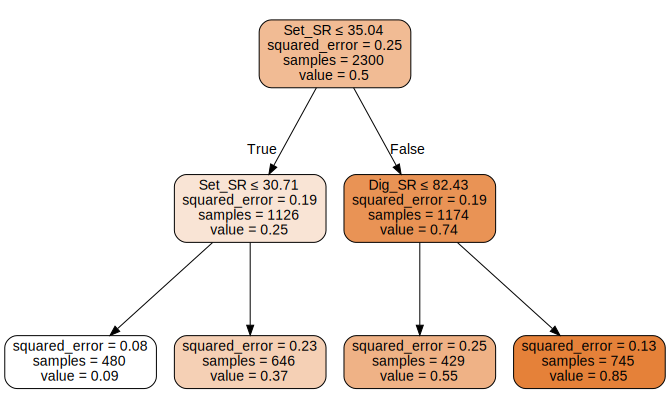

In [18]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


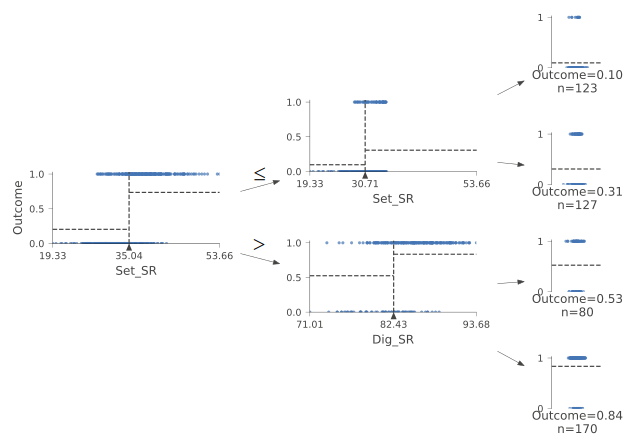

In [19]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [20]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [21]:


def sigmoid(x):
  if x>=0.5:
    return 1
  else:
    return 0

sigmoid_v = np.vectorize(sigmoid)

def r_mse(pred,y): 
  pred = sigmoid_v(pred)
  return ((pred-y)**2).mean()
  
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)



In [22]:
m_rmse(m, xs, y)

0.0

In [23]:
m_rmse(m, valid_xs, valid_y)

0.23

In [24]:
m.get_n_leaves(), len(xs)

(260, 2300)

In [25]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.16217391304347825, 0.2)

In [26]:
m.get_n_leaves()

57

### Categorical Variables

## Random Forests

In [27]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

In [28]:
def rf(xs, y, n_estimators=40, max_samples=1000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [29]:
m = rf(xs, y);

In [30]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.10130434782608695, 0.12)

In [31]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [32]:
r_mse(preds.mean(0), valid_y)

0.12

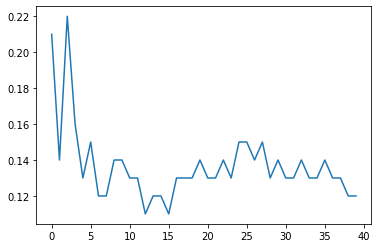

In [33]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

In [34]:
r_mse(m.oob_prediction_, y)

0.1917391304347826

## Model Interpretation

### Tree Variance for Prediction Confidence

In [35]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [36]:
preds.shape

(40, 100)

In [37]:
preds_std = preds.std(0)

In [38]:
preds_std[:5]

array([0.39112795, 0.36105455, 0.34794521, 0.36639514, 0.2710619 ])

### Feature Importance

In [39]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
20,Set_SR,0.298930
19,Dig_SR,0.138237
7,Open_SR,0.102745
23,Blocking_SR,0.084058
22,Receive_Variance,0.042789
18,Serve_SR,0.038165
27,Error,0.038068
25,Blocking_AR,0.032121
4,Share_Variance,0.025570
21,Receive_Accuracy,0.025319


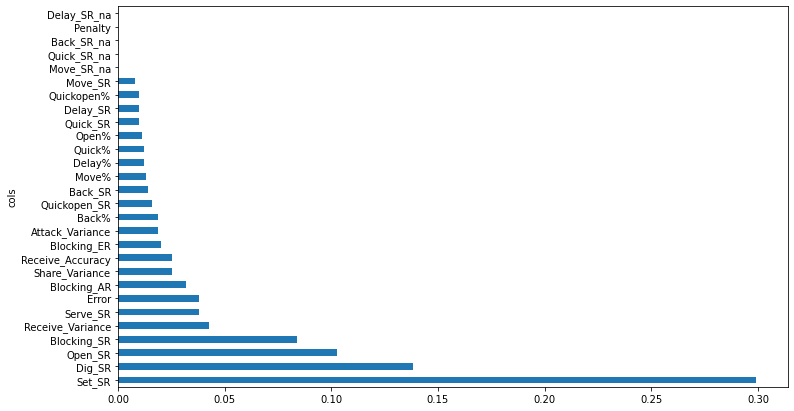

In [41]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

In [42]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

23

In [43]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [44]:
m = rf(xs_imp, y)

In [45]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.09608695652173913, 0.12)

In [46]:
len(xs.columns), len(xs_imp.columns)

(28, 23)

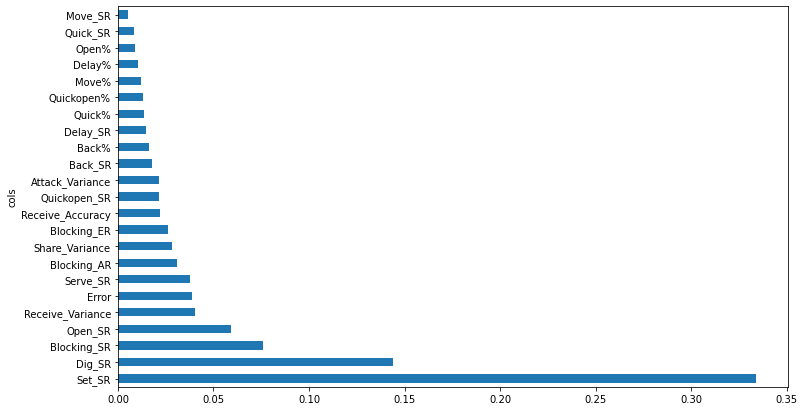

In [47]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

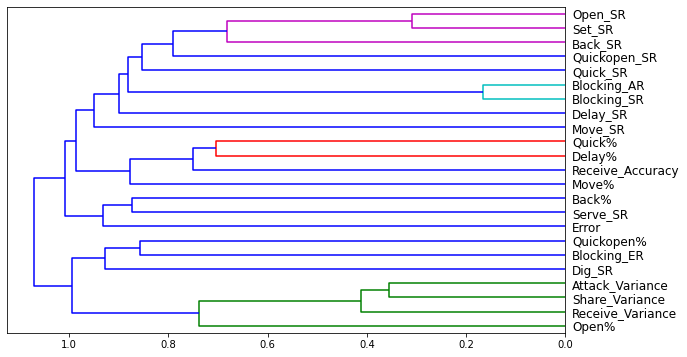

In [48]:
cluster_columns(xs_imp)

In [49]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=500, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [50]:
get_oob(xs_imp)

0.44614722915262006

In [51]:
to_drop = []
get_oob(xs_imp.drop(to_drop, axis=1))

0.45043604662065195

In [52]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [53]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)

In [54]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')

In [55]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.09, 0.11)

### Partial Dependence

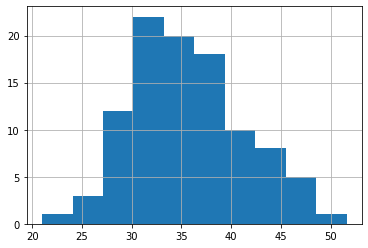

In [56]:
ax = valid_xs_final['Set_SR'].hist()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


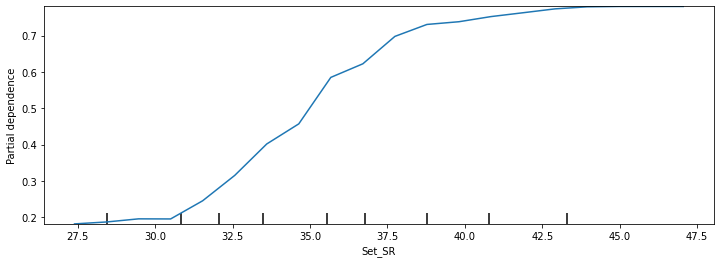

In [57]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['Set_SR'],
                        grid_resolution=20, ax=ax);

### Tree Interpreter

In [58]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [59]:
row = valid_xs_final.iloc[:5]

In [60]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [61]:
prediction[0], bias[0], contributions[0].sum()

(array([0.30377976]), 0.5028000000000001, -0.19902023809523808)

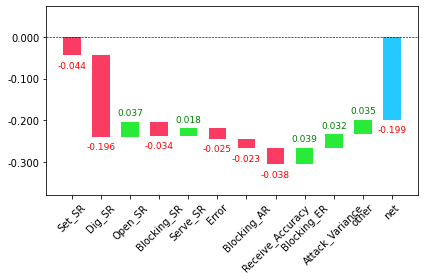

In [62]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');